In [1]:
%reload_ext autoreload
%autoreload 2

import sys

sys.path.append('../')


import pandas as pd
from generator_modules.load_dataset import load_ds

SEED: int = 42

PATH: str = '../data/transformed/'

START: str = '2024-06-11'
END: str = '2024-09-14'

print("Reading files...")
transactions_df: pd.DataFrame = load_ds(PATH, START, END)
print("Transactions read from files: ", len(transactions_df))
print("Fraudulent transactions: ", transactions_df.IS_FRAUD.sum())

Reading files...
Transactions read from files:  726864
Fraudulent transactions:  5106


In [2]:
columns_to_exclude: list = ['TRX_ID', 'CLIENT_ID', 'TERMINAL_ID', 'IS_FRAUD', 'FRAUD_SCENARIO', 'TRX_DATETIME', 'TRX_SECONDS', 'TRX_DAYS']

input_features: list = [col for col in transactions_df.columns if col not in columns_to_exclude]
output_features: str = 'IS_FRAUD'

In [3]:
import datetime

start_date_training: datetime = datetime.datetime.strptime("2024-07-25", "%Y-%m-%d")

from classification_modules.classificationClass import Classification

classificate: Classification = Classification()

(training_set, test_set) = classificate.split_train_test(transactions=transactions_df, training_start_date=start_date_training)

In [4]:
from classification_modules.normaliser import normalize_data

(training_set, test_set) = normalize_data(training_data=training_set, testing_data=test_set, feature_columns=input_features)

In [5]:
import torch

if torch.cuda.is_available():
    device: str = "cuda" 
else:
    device = "cpu"
print("Selected device is",device)

Selected device is cuda


In [6]:
from deepLearning_modules.seeder import seed_everything

seed_everything(SEED)

In [7]:
x_training_set: torch.FloatTensor = torch.FloatTensor(training_set[input_features].values)
x_test_set: torch.FloatTensor = torch.FloatTensor(test_set[input_features].values)
y_training_set: torch.FloatTensor = torch.FloatTensor(training_set[output_features].values)
y_test_set: torch.FloatTensor = torch.FloatTensor(test_set[output_features].values)

In [8]:
import torch.utils
import torch.utils.data
from deepLearning_modules.transactionsDatasetClass import TransactionDataset

training_set_params: dict = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}

test_set_params: dict = {'batch_size': 64,
          'num_workers': 0}

train_set: TransactionDataset = TransactionDataset(x_training_set, y_training_set, device)

testing_set: TransactionDataset = TransactionDataset(x_test_set, y_test_set, device)

trainer: torch.utils.data.DataLoader = torch.utils.data.DataLoader(train_set, **training_set_params)
tester: torch.utils.data.DataLoader = torch.utils.data.DataLoader(testing_set, **test_set_params)

In [9]:
criterion: torch.nn.BCELoss = torch.nn.BCELoss().to(device)

In [10]:
training_duration=7
delay_duration=7
test_duration=7

delta_valid = test_duration

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delay_duration+delta_valid))

(train_set, valid_set)=classificate.split_train_test(transactions_df,start_date_training_with_valid,
                                       training_duration=training_duration,delay_duration=delay_duration,test_duration=test_duration)

(train_set, valid_set)=normalize_data(train_set, valid_set, input_features)

In [11]:
import torch.optim.lr_scheduler as lr_scheduler

from deepLearning_modules.training_tools import prepare_data_loaders
from deepLearning_modules.training_tools import train_model_earlystopping_metrics

from deepLearning_modules.funnelMLPClass import DeepFunnelTransactionMLP

seed_everything(SEED)

model_name: str = 'best_funnel.pth'

model = DeepFunnelTransactionMLP(len(input_features)).to(device)

trainer, validator = prepare_data_loaders(train_df=train_set, valid_df=valid_set, input_features=input_features, output_feature=output_features, batch_size=64, device=device)

criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

results = train_model_earlystopping_metrics(model=model, trainer=trainer, validator=validator, optimizer=optimizer, criterion=criterion, patience=3, max_epochs=500, verbose=True, model_name=model_name, scheduler=scheduler)

trained_model = results['model']
training_time = results['training_time']
train_loss = results['train_losses']
valid_loss = results['valid_losses']

c:\Users\gc042\OneDrive\Desktop\Projects\datamining_proj\datamining_proj\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500: train loss: 0.06053799624057276
New best score: 0.021213416872837117
Model checkpoint saved at: ./models/best/best_funnel.pth
Epoch 2/500: train loss: 0.022614743320603425
1 iterations since the best score.
Epoch 3/500: train loss: 0.022345074957108732
2 iterations since the best score.
Epoch 4/500: train loss: 0.022371587387724136
New best score: 0.01885481870008931
Model checkpoint saved at: ./models/best/best_funnel.pth
Epoch 5/500: train loss: 0.021936568038531307
1 iterations since the best score.
Epoch 6/500: train loss: 0.021025602590511287
New best score: 0.01777100034558371
Model checkpoint saved at: ./models/best/best_funnel.pth
Epoch 7/500: train loss: 0.020482422440611343
1 iterations since the best score.
Epoch 8/500: train loss: 0.01937882215396706
New best score: 0.01748163129163139
Model checkpoint saved at: ./models/best/best_funnel.pth
Epoch 9/500: train loss: 0.018595074533753135
New best score: 0.01693841212113433
Model checkpoint saved at: ./models/bes

In [12]:
print(f"Final Validation Metrics:\n"
          f"Accuracy: {results['final_metrics']['accuracy']:.4f}\n"
          f"Precision: {results['final_metrics']['precision']:.4f}\n"
          f"Recall: {results['final_metrics']['recall']:.4f}\n"
          f"F1 Score: {results['final_metrics']['f1']:.4f}\n"
          f"AUC-ROC: {results['final_metrics']['auc_roc']:.4f}\n"
          f"Average Precision: {results['final_metrics']['average_precision']:.4f}\n"
          f"Top-K Accuracy: {results['final_metrics']['top_k_accuracy']:.4f}")

Final Validation Metrics:
Accuracy: 0.9967
Precision: 0.7774
Recall: 0.6290
F1 Score: 0.6954
AUC-ROC: 0.8709
Average Precision: 0.6595
Top-K Accuracy: 0.9700


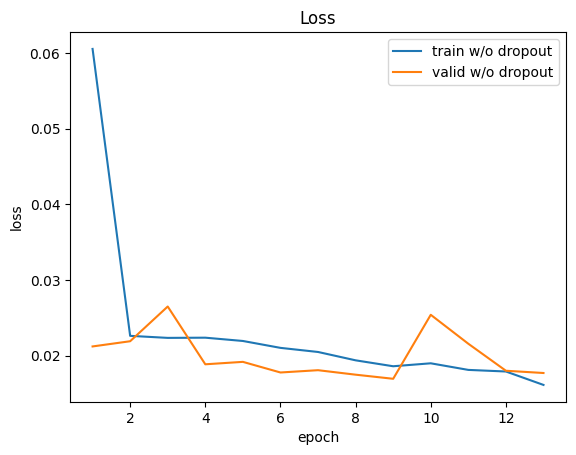

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_loss))+1, train_loss)
plt.plot(np.arange(len(valid_loss))+1, valid_loss)
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o dropout','valid w/o dropout'])

In [14]:
from deepLearning_modules.funnelMLPDropoutClass import FunnelTransactionMLPWithDropout

seed_everything(SEED)

model_name: str = 'best_funnel_dropout.pth'

model = FunnelTransactionMLPWithDropout(len(input_features), 0.4).to(device)

trainer, validator = prepare_data_loaders(train_df=train_set, valid_df=valid_set, input_features=input_features, output_feature=output_features, batch_size=64, device=device)

criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

results = train_model_earlystopping_metrics(model=model, trainer=trainer, validator=validator, optimizer=optimizer, criterion=criterion, patience=3, max_epochs=500, verbose=True, model_name=model_name, scheduler=scheduler)

trained_model = results['model']
training_time = results['training_time']
train_loss_dropout = results['train_losses']
valid_loss_dropout = results['valid_losses']

c:\Users\gc042\OneDrive\Desktop\Projects\datamining_proj\datamining_proj\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500: train loss: 0.07078925496000561
New best score: 0.027295697479808815
Model checkpoint saved at: ./models/best/best_funnel_dropout.pth
Epoch 2/500: train loss: 0.029954859856002495
New best score: 0.021553363443105152
Model checkpoint saved at: ./models/best/best_funnel_dropout.pth
Epoch 3/500: train loss: 0.027996893925381485
1 iterations since the best score.
Epoch 4/500: train loss: 0.02736549922892638
New best score: 0.021031338235468263
Model checkpoint saved at: ./models/best/best_funnel_dropout.pth
Epoch 5/500: train loss: 0.027032401759041865
New best score: 0.0193521497005271
Model checkpoint saved at: ./models/best/best_funnel_dropout.pth
Epoch 6/500: train loss: 0.025696431245715166
New best score: 0.018853497154187746
Model checkpoint saved at: ./models/best/best_funnel_dropout.pth
Epoch 7/500: train loss: 0.024566108181390135
1 iterations since the best score.
Epoch 8/500: train loss: 0.02485956254730127
2 iterations since the best score.
Epoch 9/500: train los

In [15]:
print(f"Final Validation Metrics:\n"
          f"Accuracy: {results['final_metrics']['accuracy']:.4f}\n"
          f"Precision: {results['final_metrics']['precision']:.4f}\n"
          f"Recall: {results['final_metrics']['recall']:.4f}\n"
          f"F1 Score: {results['final_metrics']['f1']:.4f}\n"
          f"AUC-ROC: {results['final_metrics']['auc_roc']:.4f}\n"
          f"Average Precision: {results['final_metrics']['average_precision']:.4f}\n"
          f"Top-K Accuracy: {results['final_metrics']['top_k_accuracy']:.4f}")

Final Validation Metrics:
Accuracy: 0.9968
Precision: 0.9048
Recall: 0.5108
F1 Score: 0.6529
AUC-ROC: 0.8546
Average Precision: 0.6276
Top-K Accuracy: 0.9700


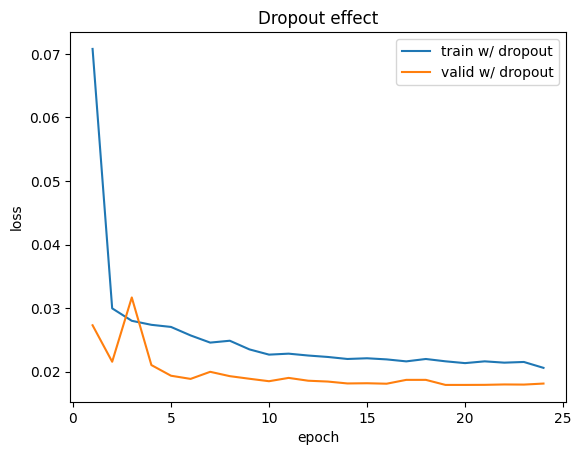

In [16]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_loss_dropout))+1, train_loss_dropout)
plt.plot(np.arange(len(valid_loss_dropout))+1, valid_loss_dropout)
plt.title("Dropout effect")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/ dropout','valid w/ dropout'])